<a href="https://colab.research.google.com/github/Hassan-293/My-Project/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/MyDrive/Histo Data'

Consep		lizard_images2	overlay    processed_masked
lizard_images1	lizard_labels	processed


In [3]:
!mkdir '/content/drive/MyDrive/Histo Data/processed'

mkdir: cannot create directory ‘/content/drive/MyDrive/Histo Data/processed’: File exists


In [4]:
from tensorflow import keras
import cv2

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path ='/content/drive/MyDrive/Histo Data/lizard_images2/Lizard_Images2'
processed_path = '/content/drive/MyDrive/Histo Data/processed'

for filename in os.listdir(path):
    if filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(path, filename))

        # Resize the image
        image = cv2.resize(image, (256, 256))
        
        # Standardize the data by subtracting the mean and dividing by the standard deviation
        image = (image - np.mean(image)) / np.std(image)

        # Normalize the image
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        
        # Save the processed image
        cv2.imwrite(f'/content/drive/MyDrive/Histo Data/processed/'+ filename.split('/')[-1], image)
           

In [6]:

def display_image(image_path):
    # Load the image
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.show()

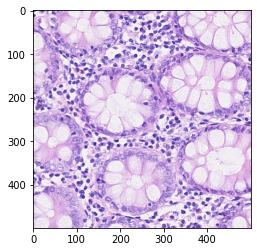

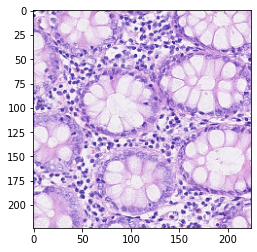

In [7]:
Unprocessed_Image='/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1/consep_11.png'
Processed_Image= '/content/drive/MyDrive/Histo Data/processed/consep_11.png'

display_image(Unprocessed_Image)

display_image(Processed_Image)



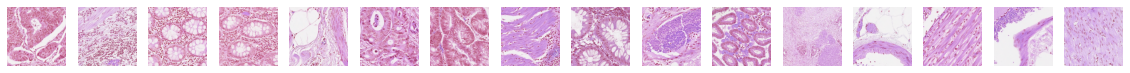

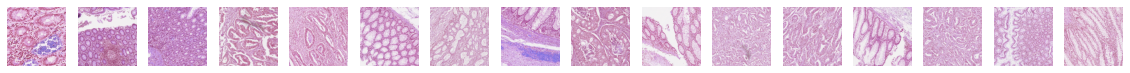

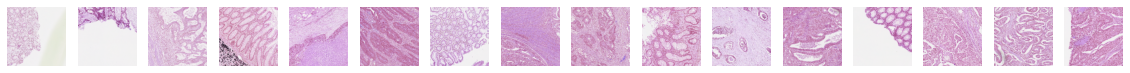

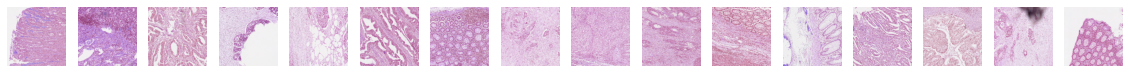

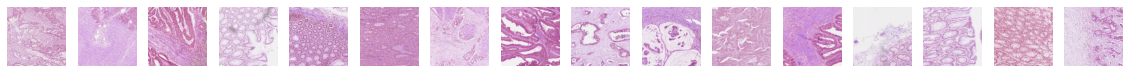

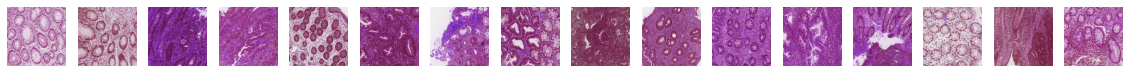

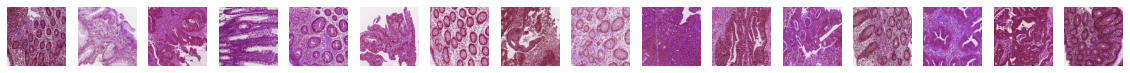

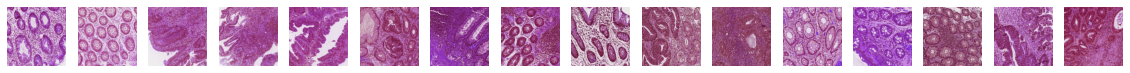

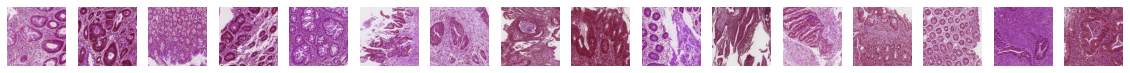

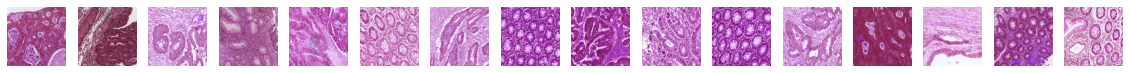

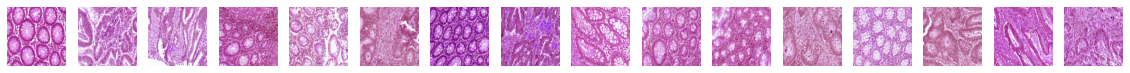

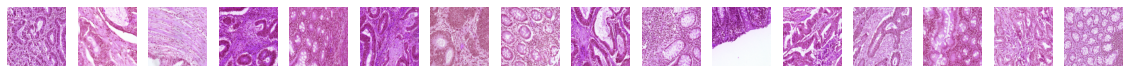

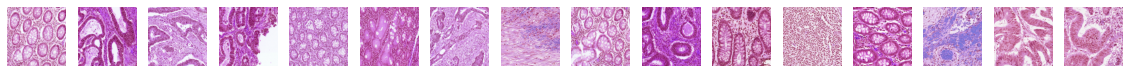

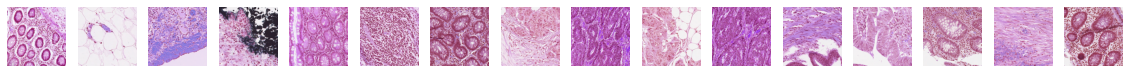

In [8]:
import glob

# Find all the images in the folder
image_files = glob.glob('/content/drive/MyDrive/Histo Data/processed/*.png')

# Load the images in a list
images = []
for file in image_files:
    img = cv2.imread(file)
    images.append(img)

# Divide the images into batches
batch_size = 16
num_batches = len(images) // batch_size
for i in range(num_batches):
    batch_images = images[i * batch_size:(i + 1) * batch_size]
    # Plot the images
    fig, axs = plt.subplots(1, len(batch_images), figsize=(20, 5))
    for i, img in enumerate(batch_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()


In [9]:
train_image_dir = r'/content/drive/MyDrive/Histo Data/processed'
train_mask_dir = r'/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels'

In [10]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".mat") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

Number of training images :  238
Number of training masks :  238


In [11]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [12]:
print("After shuffling")
print(train_image_paths[0:5])
print(train_mask_paths[0:5])
# Sequence intact !

After shuffling
['/content/drive/MyDrive/Histo Data/processed/dpath_58.png', '/content/drive/MyDrive/Histo Data/processed/glas_16.png', '/content/drive/MyDrive/Histo Data/processed/crag_39.png', '/content/drive/MyDrive/Histo Data/processed/consep_10.png', '/content/drive/MyDrive/Histo Data/processed/crag_49.png']
['/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels/dpath_58.mat', '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels/glas_16.mat', '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels/crag_39.mat', '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels/consep_10.mat', '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels/crag_49.mat']


In [13]:
# Splitting
train_image_files = train_image_paths[:190]
train_mask_files = train_mask_paths[:190]

valid_image_files = train_image_paths[190:]
valid_mask_files = train_mask_paths[190:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


190 190
48 48


**Pre-Processing-Labels**

In [28]:
'''import os
import cv2
import numpy as np
import h5py

source_dir = '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels'
dest_dir = '/content/drive/MyDrive/Histo Data/processed_masked'

# Create the destination directory if it does not exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Loop over all the files in the source directory
for file_name in os.listdir(source_dir):
    # Check if the file is a .mat file
    if file_name.endswith('.mat'):
        # Load the .mat file
        with h5py.File(os.path.join(source_dir, file_name), 'r') as f:
            mat_data = f['centroid'][:]
        mat_data = np.transpose(mat_data)

        # Extract the mask from the .mat file
        mask = np.int8(mat_data)

        # Resize the mask to 256x256 using nearest neighbor interpolation
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Normalize the mask to be between 0 and 1
        mask = mask.astype(np.float32) / 255.0

        # Save the processed mask as a PNG file to the destination directory
        cv2.imwrite(os.path.join(dest_dir, file_name.replace('.mat', '.png')), mask*255)
'''

"import os\nimport cv2\nimport numpy as np\nimport h5py\n\nsource_dir = '/content/drive/MyDrive/Histo Data/lizard_labels/Lizard_Labels/Labels'\ndest_dir = '/content/drive/MyDrive/Histo Data/processed_masked'\n\n# Create the destination directory if it does not exist\nif not os.path.exists(dest_dir):\n    os.makedirs(dest_dir)\n\n# Loop over all the files in the source directory\nfor file_name in os.listdir(source_dir):\n    # Check if the file is a .mat file\n    if file_name.endswith('.mat'):\n        # Load the .mat file\n        with h5py.File(os.path.join(source_dir, file_name), 'r') as f:\n            mat_data = f['centroid'][:]\n        mat_data = np.transpose(mat_data)\n\n        # Extract the mask from the .mat file\n        mask = np.int8(mat_data)\n\n        # Resize the mask to 256x256 using nearest neighbor interpolation\n        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)\n\n        # Normalize the mask to be between 0 and 1\n        mask = mask.as